In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor as catb

import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family = 'Apple SD Gothic Neo') # 그래프에서 한글 깨지는 현상 방지
plt.rc('axes', unicode_minus=False) # 그래프에서 마이너스 기호가 표시되도록

In [21]:
# 데이터 경로 설정
data_dir = os.getenv('HOME')+'/Aiffel/kaggle/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')


# 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호    
2. **date : 집을 구매한 날짜**    
3. price : 타겟 변수인 집의 가격    
4. **bedrooms : 침실의 수**    
5. **bathrooms : 침실당 화장실 개수**    
6. sqft_living : 주거 공간의 평방 피트    
7. sqft_lot : 부지의 평방 피트    
8. **floors : 집의 층 수**    
9. **waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)**    
10. **view : 집이 얼마나 좋아 보이는지의 정도**     
11. **condition : 집의 전반적인 상태**     
12. **grade : King County grading 시스템 기준으로 매긴 집의 등급**      
13. sqft_above : 지하실을 제외한 평방 피트     
14. sqft_basement : 지하실의 평방 피트   
15. **yr_built : 집을 지은 년도**    
16. **yr_renovated : 집을 재건축한 년도**     
17. zipcode : 우편번호   
18. lat : 위도     
19. long : 경도     
20. **sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)**     
21. **sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)**


In [22]:
# 데이터 불러오기 및 shape 확인
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [23]:
# 라벨 분리하기
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [24]:
# 데이터 합치기
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

21503


In [25]:
# 제출을 위한 sub_id 저장
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


# EDA 

## 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

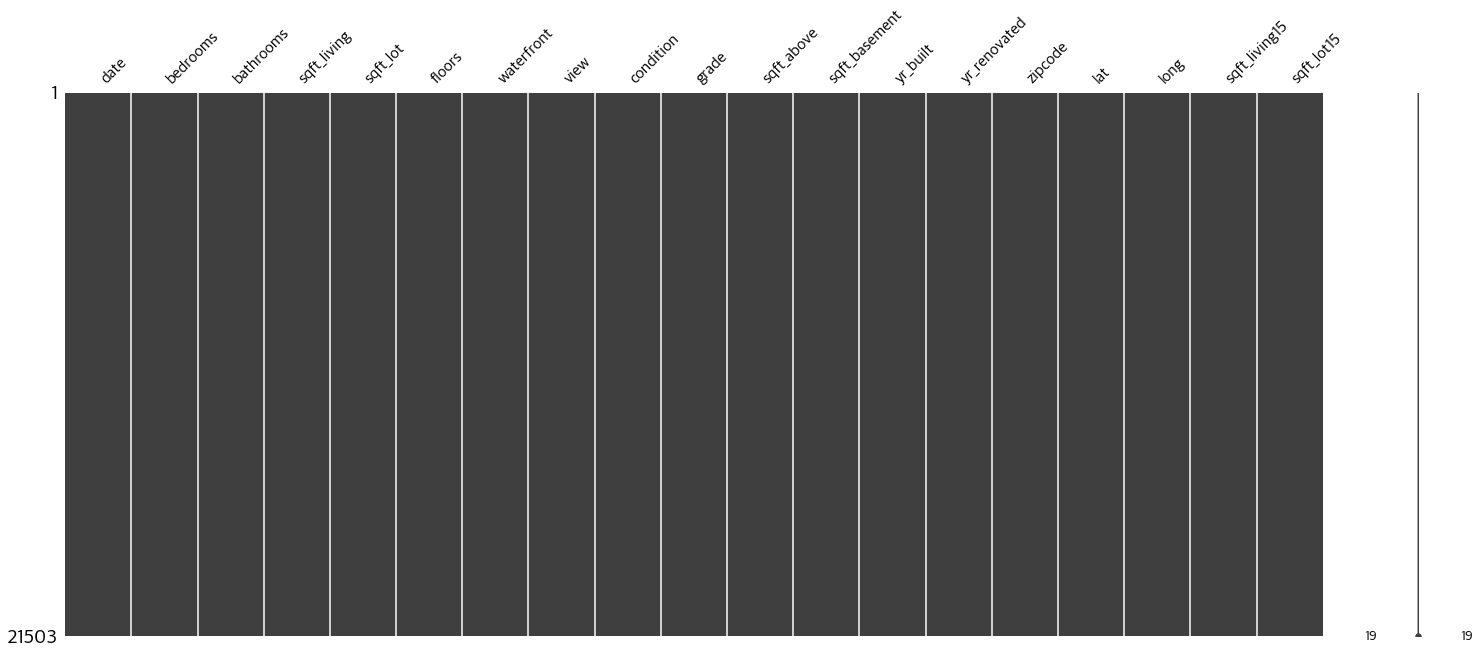

In [26]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [27]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


## 변수 선택
직관적으로 집값 예측에 중요하지 않다고 생각되는 **우편번호는 제외**시키겠습니다.        
**재건축**에 대한 데이터들도 있는데 **현재 집 상태가 중요**하므로 제거해주는 쪽으로 고려하겠습니다.  

In [28]:
data[data['sqft_basement'] != 0][['sqft_living15', 'sqft_basement', 'sqft_above', 'sqft_living']]

,sqft_living15,sqft_basement,sqft_above,sqft_living
5,2210,1700,1860,3560
6,1330,300,860,1160
10,2140,970,1980,2950
15,1400,760,860,1620
16,4110,720,2330,3050
...,...,...,...,...
6453,1670,320,1350,1670
6456,3470,1310,3540,4850
6458,1310,320,940,1260
6461,1530,50,1480,1530


**지하실의 평방피트**가 재건축 이전인지 이후인지 알 수 없어 살펴본 결과 지하실의 평방피트 + 지하실을 제외한 평방피트 = 재건축 이전 주거공간 평방피트이므로 **재건축 이전의 데이터**임을 확인하였습니다. 지하실이 클 경우 실제 거주 공간은 작으므로 유용한 지표가 되겠지만 현재 지하실이 그대로 유지되었는지 재건축과 함께 사라졌는지 확인할 방법이 없어 **feature에서 제외**시키기로 했습니다.

In [29]:
data['yr_renovated'].unique()

array([   0, 2002, 1999, 1991, 1978, 2005, 2008, 2003, 1994, 1984, 1954,
       2014, 2011, 1974, 1983, 2013, 1990, 1957, 1977, 1981, 1995, 2000,
       1986, 1992, 2004, 2007, 1987, 2006, 1985, 1971, 1945, 1979, 1997,
       2010, 1969, 1948, 2009, 1970, 2015, 1989, 2001, 1968, 2012, 1963,
       1993, 1962, 1972, 1980, 1998, 1955, 1996, 1950, 1956, 1982, 1988,
       1940, 1946, 1975, 1964, 1958, 1976, 1973, 1967, 1965, 1944, 1951,
       1953, 1959, 1960, 1934])

In [30]:
# 'year' 변수에 집이 만들어진 가장 최근 년도 입력
data['year'] = np.where(data['yr_renovated']==0, data['yr_built'], data['yr_renovated'])

재건축이 안 된 집들은 'yr_renovated'의 값이 0으로 설정되어 있습니다. **'yr_renovate'가 0인 경우에는 'yr_built'의 값을 가져오고 0이 아닌 경우는 재건축 년도를 가져와 'year' 변수에 통합**해줍니다.

In [31]:
# 불필요한 column 제거
data = data.drop(columns = ['yr_built', 'yr_renovated', 'zipcode','sqft_above','sqft_lot','sqft_basement','sqft_living'])
sub = sub.drop(columns = ['yr_built', 'yr_renovated', 'zipcode', 'sqft_above','sqft_lot','sqft_basement','sqft_living'])

In [32]:
# 날짜는 년, 월만 나오도록 전처리
data['date'] = data['date'].apply(lambda x : x[:6]).astype(int)
sub['date'] = sub['date'].apply(lambda x : x[:6]).astype(int)
data.head()

,date,bedrooms,bathrooms,floors,waterfront,view,condition,grade,lat,long,sqft_living15,sqft_lot15,year
0,201410,3,1.00,1.0,0,0,3,7,47.5112,-122.257,1340,5650,1955
1,201502,2,1.00,1.0,0,0,3,6,47.7379,-122.233,2720,8062,1933
2,201502,3,2.00,1.0,0,0,3,8,47.6168,-122.045,1800,7503,1987
3,201406,3,2.25,2.0,0,0,3,7,47.3097,-122.327,2238,6819,1995
4,201501,3,1.50,1.0,0,0,3,7,47.4095,-122.315,1650,9711,1963


## 이상치 확인

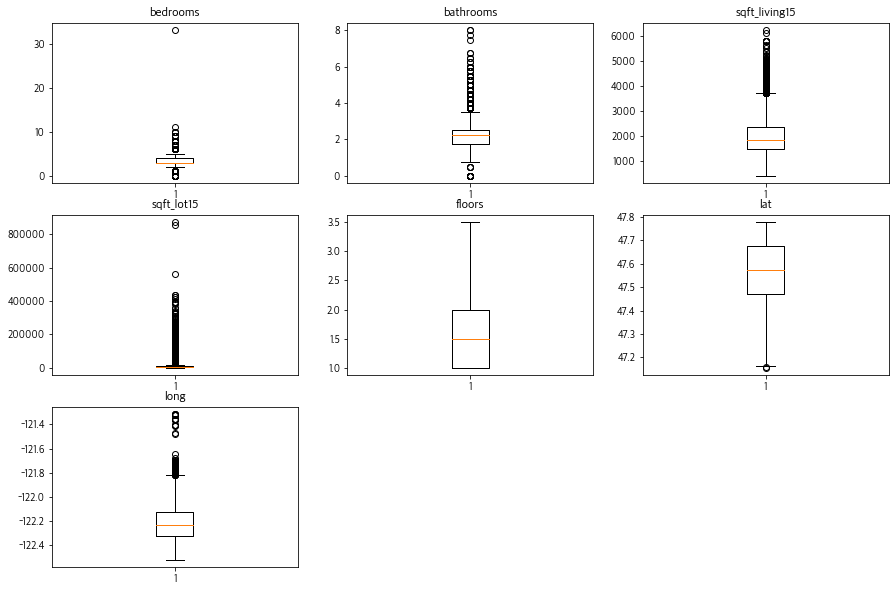

In [47]:
# 수치형 데이터
numerical_data_list = ['bedrooms', 'bathrooms', 'sqft_living15', 'sqft_lot15', 'floors', 'lat', 'long']
outlier_df = data[numerical_data_list]

plt.figure(figsize=(15,10))
for i in range(len(numerical_data_list)):
    plt.subplot(3,3,i+1)
    plt.boxplot(outlier_df.iloc[:,i])
    plt.title(numerical_data_list[i])

이상치들이 많이 보이기는 하나 대부분의 사람들이 2~4개의 방과 화장실, 적당한 크기의 평범한 집에 살며, **소수의 부유층**만이 압도적으로 넓은 집에 살기 때문임으로 예상됩니다. **데이터의 오류 같지는 않으므로 제거해주지는 않겠습니다.** 위도와 경도 또한 이상치로는 나타나나 값에 큰 차이가 있지는 않으므로 제거하지 않겠습니다.

## 변수와 target의 관계 분석
침실 수, 화장실 수, 층수,강의 유무, 집의 외관, 집의 상태, 등급, 건축년도, 주거공간 크기, 부지의 크기 

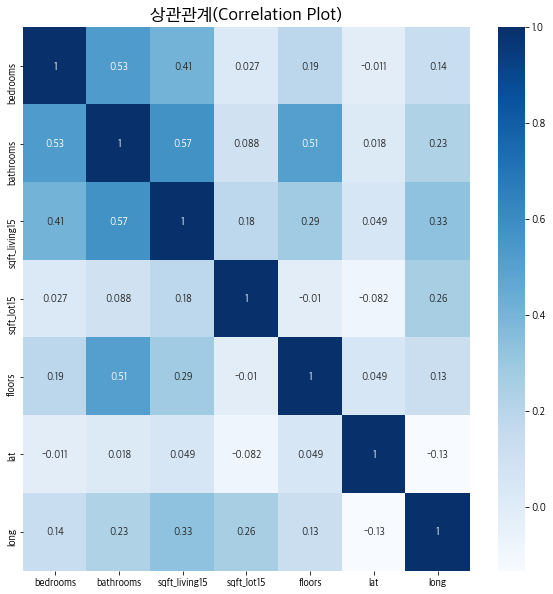

In [48]:
corr_df = pd.concat([data[:train_len], y], axis=1)

plt.figure(figsize=(10,10))
plt.title('상관관계(Correlation Plot)', fontsize = 18)
sns.heatmap(corr_df[numerical_data_list].corr(),cmap='Blues', annot=True)
plt.show()

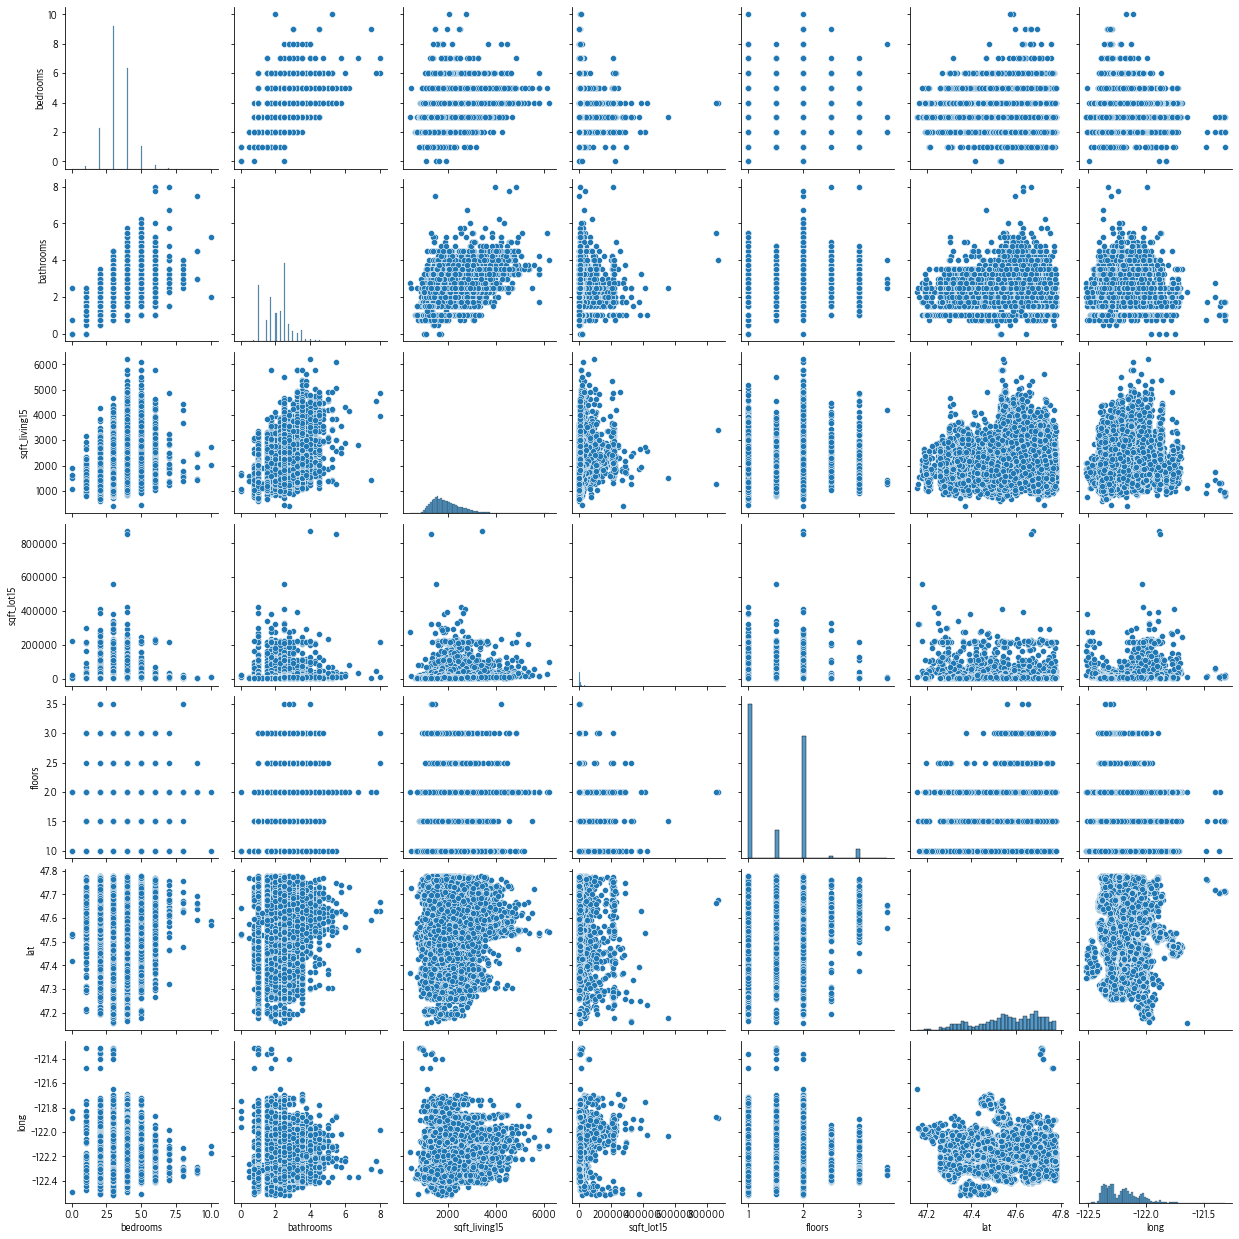

In [49]:
sns.pairplot(corr_df[numerical_data_list])

target인 **가격과의 관계**를 살펴보면 **등급이 0.67로 가장 높은 양의 관계**를 보입니다. feature들 간에는 **등급이 화장실의 수, 주거 공간 크기와 꽤나 높은 상관관계**를 보입니다. 등급 자체가 다른 요소들에 의해 평가될 것이기 때문으로 예상되며 **다중공선성**이 있을지 모르니 확인해보겠습니다.

In [50]:
# VIF 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
vif["features"] = data.columns
vif.sort_values(["VIF Factor"], ascending=[False])

,VIF Factor,features
0,1.146290e+06,date
9,1.002702e+06,long
8,1.282540e+05,lat
12,1.012964e+04,year
7,1.249560e+02,grade
6,3.516044e+01,condition
10,2.317355e+01,sqft_living15
2,2.313613e+01,bathrooms
1,2.058756e+01,bedrooms
3,1.383869e+01,floors


일반적으로 VIF가 10 이상이면 제거해주는걸로 알고 있는데 전체적으로 다 너무 높은 값이 나오네요..   
이유를 모르겠어서 feature는 전부 그대로 두겠습니다.

## 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

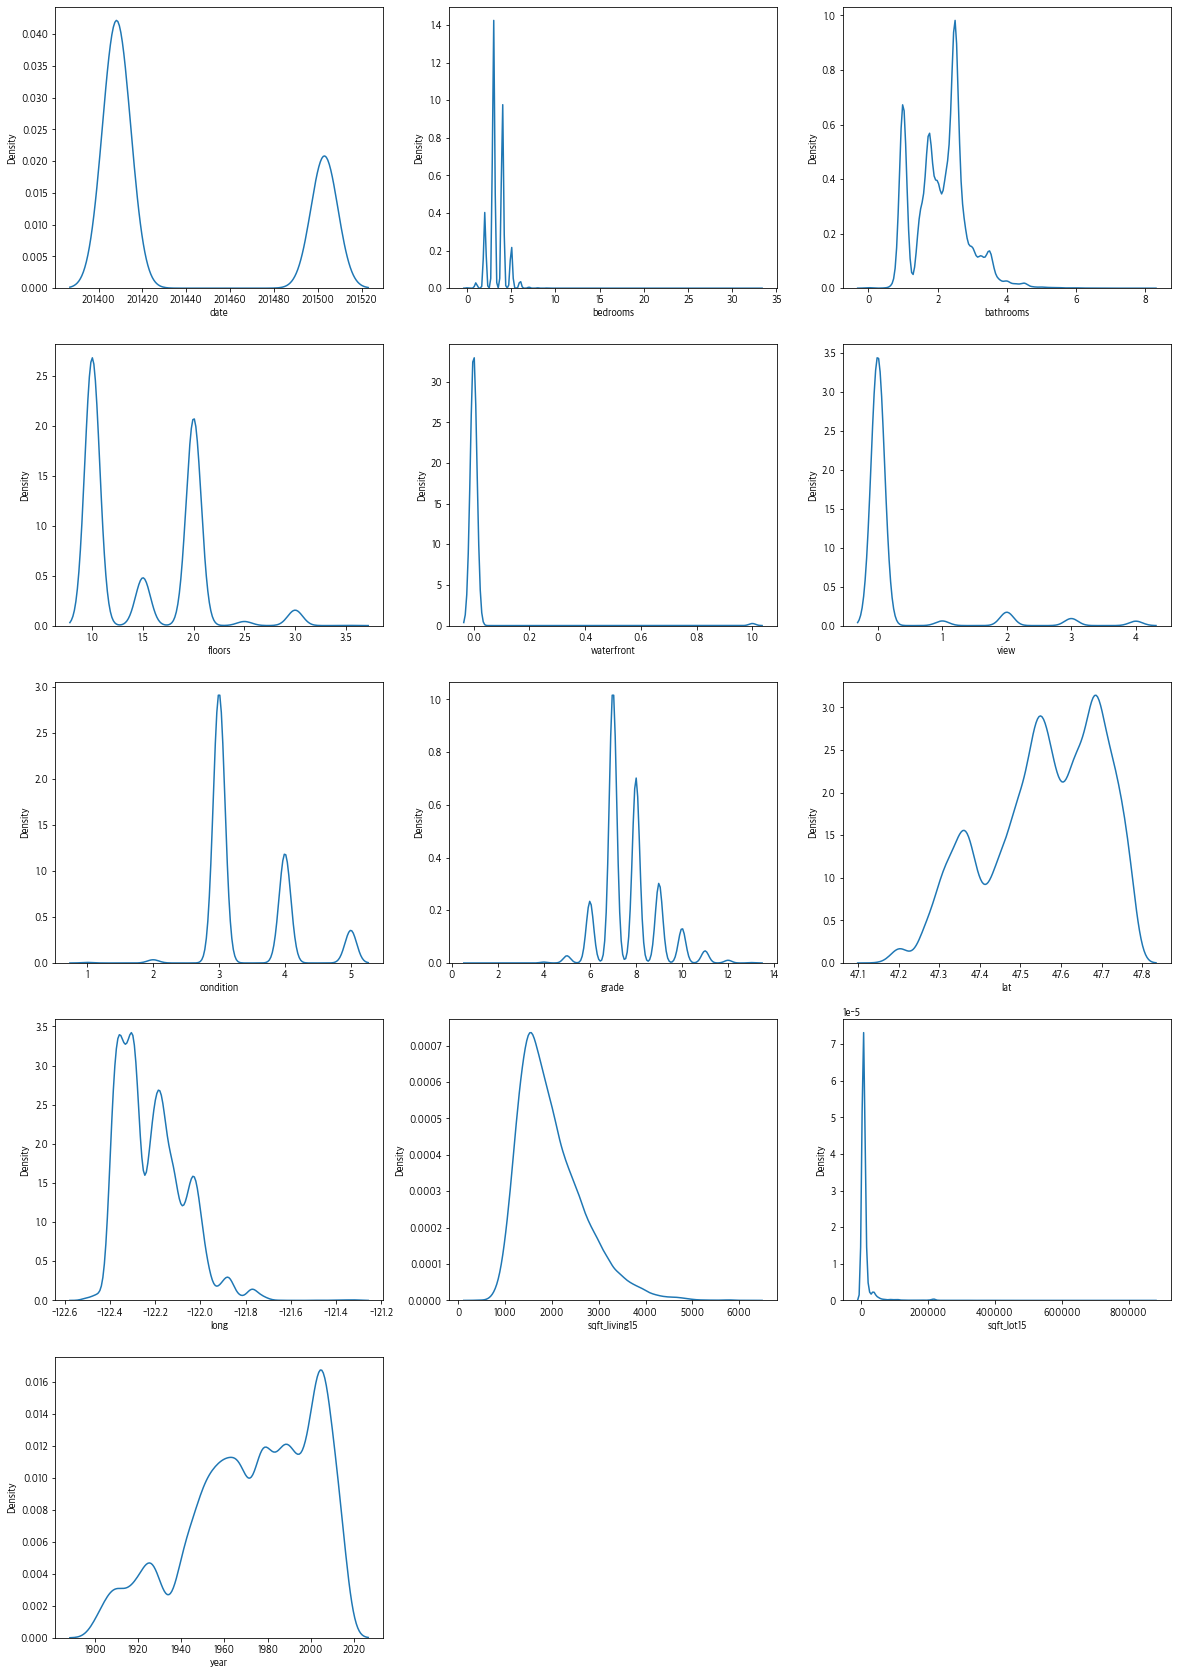

In [33]:
columns = data.columns

plt.figure(figsize=(20,30))
for i in range(len(columns)):
    plt.subplot(5,3,i+1)
    sns.kdeplot(data[columns[i]])

**sqft_lot15이 한쪽으로 치우친 경향**을 보였습니다.<br>
**log-scaling**을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

<AxesSubplot:xlabel='price', ylabel='Density'>

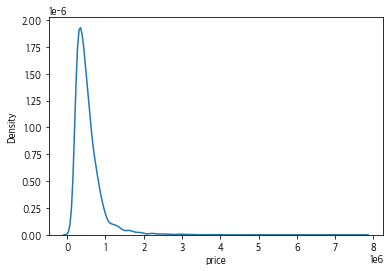

In [34]:
sns.kdeplot(y)

target인 **가격도 왼쪽으로 치우쳐 있습니다.** 함께 **log-scaling**을 해주겠습니다.

Text(0.5, 1.0, 'y')

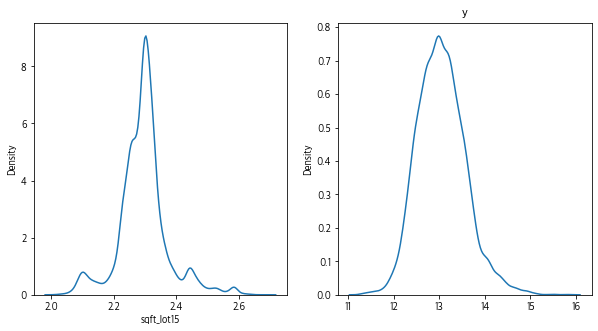

In [37]:
data['sqft_lot15'] = np.log1p(data['sqft_lot15'].values)
y = np.log1p(y.values)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.kdeplot(data['sqft_lot15'])
plt.subplot(1,2,2)
sns.kdeplot(y)
plt.title('y')

어느정도 **치우침이 줄어든 분포**를 확인할 수 있습니다.

# One-hot Encoding
범주형 변수들을 원핫인코딩 형태로 만들어주겠습니다.

In [38]:
categorical_list = ['waterfront','view', 'condition', 'grade', 'date']
for cat in categorical_list:
    data[cat] = data[cat].astype(str)
X = pd.get_dummies(data, columns=categorical_list)
X.tail()

,bedrooms,bathrooms,floors,lat,long,sqft_living15,sqft_lot15,year,waterfront_0,waterfront_1,...,date_201408,date_201409,date_201410,date_201411,date_201412,date_201501,date_201502,date_201503,date_201504,date_201505
6463,3,1.75,1.0,47.3095,-122.002,1320,2.335334,2014,1,0,...,0,0,0,0,0,0,0,0,0,0
6464,3,2.00,3.0,47.5699,-122.288,1400,2.093786,2014,1,0,...,0,0,0,0,0,1,0,0,0,0
6465,3,2.50,2.0,47.5773,-122.409,1330,2.097235,2008,1,0,...,0,0,0,0,0,0,1,0,0,0
6466,2,0.75,2.0,47.5944,-122.299,1020,2.152331,2009,1,0,...,0,0,0,0,0,0,0,0,0,0
6467,3,2.50,2.0,47.5345,-122.069,1410,2.099348,2004,1,0,...,0,0,0,0,0,1,0,0,0,0


In [134]:
# train, sub 분리
sub = X.iloc[train_len:, :]
train_X = X.iloc[:train_len, :]

print(train_X.shape)
print(sub.shape)

(15035, 45)
(6468, 45)


열심히 EDA를 진행해보았지만 노드에서처럼 **모든 변수를 사용하고 log 변환만 해주는게 성능이 더 좋았습니다.** 머신러닝 모델이 저보다 중요한 feature들을 더 잘 잡나봅니다..모든 변수를 사용하는 방식으로 다시 전처리 하겠습니다.

# 전처리(실제 사용 데이터)

In [39]:
# 데이터 경로 설정
data_dir = os.getenv('HOME')+'/Aiffel/kaggle/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')


In [40]:
# 데이터 불러오기 및 shape 확인
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [41]:
# 라벨 분리하기
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [42]:
# 데이터 합치기
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

21503


In [43]:
# 제출을 위한 sub_id 저장
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [44]:
# 날짜는 년, 월만 나오도록 전처리
data['date'] = data['date'].apply(lambda x : x[:6]).astype(int)
sub['date'] = sub['date'].apply(lambda x : x[:6]).astype(int)
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


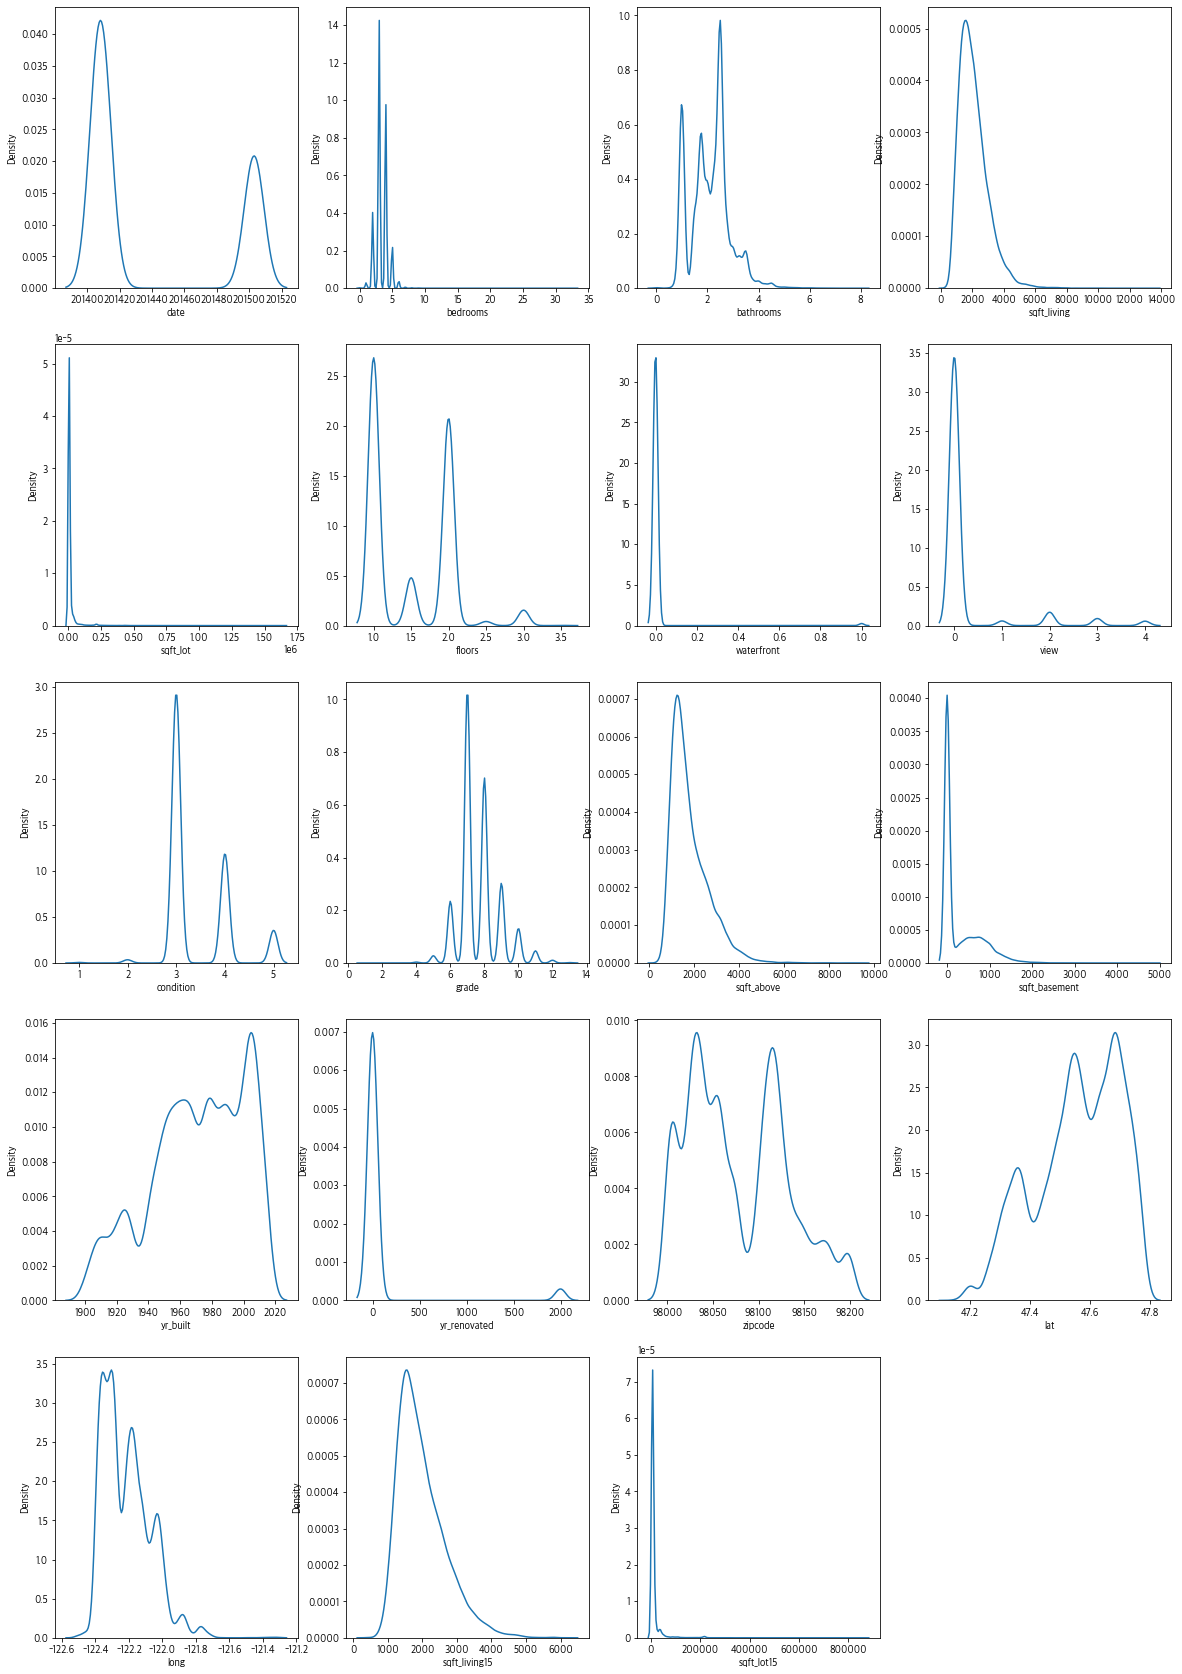

In [46]:
# 변수들의 분포 확인
columns = data.columns

plt.figure(figsize=(20,30))
for i in range(len(columns)):
    plt.subplot(5,4,i+1)
    sns.kdeplot(data[columns[i]])

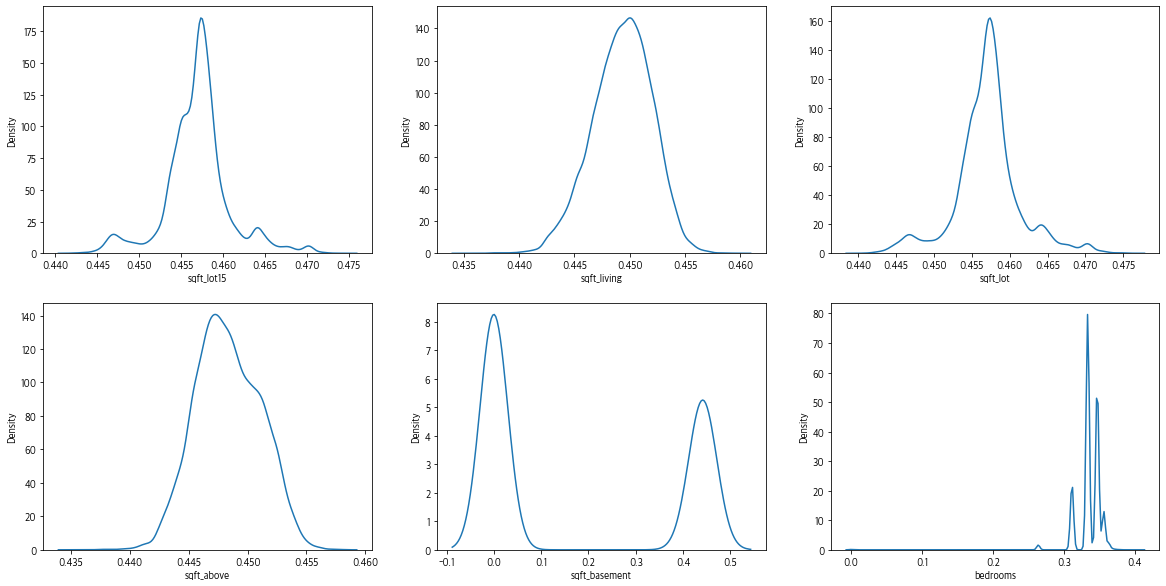

In [54]:
# 로그 스케일링
skew_list = ['sqft_lot15', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'bedrooms']
for col in skew_list:
    data[col] = np.log1p(data[col].values)

plt.figure(figsize=(20,10))
for i, col in enumerate(skew_list):
    plt.subplot(2,3,i+1)
    sns.kdeplot(data[col])    

# target 로그 스케일링
y = np.log1p(y.values)

In [55]:
# train, sub 분리
train_X = data[:train_len]
sub = data[train_len:]

# 그리드서치

In [56]:
from sklearn.model_selection import GridSearchCV

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

## XGboost

### 특징
- GBM보다 빠르다.
- 과적합 방지가 가능한 규제가 포함되어 있다.
- 분류와 회귀가 모두 가능하다.
- 조기 종료(early stopping)을 제공한다.
- Gradient Boost를 기반으로 한다. 즉, 가중치 부여를 경사하강법으로 한다.

### 파라미터

- **n_estimators**: 반복하려는 트리의 개수
- **learning_rage**: 학습률. 낮은 값일수록 모델이 견고해지고 오버 피팅 방지에 좋다.

- **max_depth**: 최대 트리의 깊이. N일 때 $2^N$개의 리프 노드가 생긴다. Feature 수에 따라 3~6으로 세팅 후 성능이 증가하고 오버피팅이 나지 않을 때까지 늘려나간다.
- **min_child_weight**: child의 관측에서 요구되는 최소 가중치의 합. 오버피팅 방지
- **subsample**: 매 스탭마다 사용할 샘플의 비율. 1이하의 값을 사용하면 오버피팅 방지에 도움이 된다.
- **colsample_bytree**: 각각의 트리(스탭)마다 사용할 Feature의 비율. Feature가 너무 많거나 소수의 Featuredp 지나치게 의존적일 때 유용하다.
- **gamma**: 분할을 수행하는데 필요한 최소 손실 감소를 지정한다. 모델을 보수적으로 만든다.
- **lambda**: L2정규화. 클수록 보수적인 모델을 생성하고 오버피팅을 방지한다. noise나 outlier 같이 튀는 데이터들을 잡아준다.
- **alpha**: L1정규화. 클수록 보수적인 모델을 생성하고 오버피팅을 방지한다. sparse feature가 있거나 feature 수가 지나치게 많을 때 효과적이다.
- **early_stopping**: N번 동안 성능이 좋아지지 않으면 training을 조기 종료한다.


### max_depth / min_child_weight 튜닝

In [59]:
param_test1 = {
 'max_depth':range(3,10,3),
 'min_child_weight':range(1,6,2)
}

xgb_model1 = xgb.XGBRegressor(
    objective= 'reg:squaredlogerror', #objective에 맞춰 eval_metric이 rmsle로 설정
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    reg_lambda=1,
    alpha=0,
    subsample=0.8,
    colsample_bytree=0.8,
    nthread=-1,
    scale_pos_weight=1,
    seed=2019
)

my_GridSearch(xgb_model1, train_X, y, param_grid = param_test1)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


,max_depth,min_child_weight,score,RMSLE
3,6,1,-0.027274,0.165147
6,9,1,-0.027442,0.165655
0,3,1,-0.028256,0.168095
4,6,3,-0.029534,0.171854
7,9,3,-0.029553,0.171911
1,3,3,-0.030642,0.175048
5,6,5,-0.033140,0.182044
8,9,5,-0.033221,0.182267
2,3,5,-0.034614,0.186048


### gamma 튜닝

In [60]:
param_test2 = {
    'gamma':[i/10.0 for i in range(0,5)]
}

xgb_model2 = xgb.XGBRegressor(
    objective= 'reg:squaredlogerror', #objective에 맞춰 eval_metric이 rmsle로 설정
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=6,
    min_child_weight=1,
    gamma=0,
    reg_lambda=1,
    alpha=0,
    subsample=0.8,
    colsample_bytree=0.8,
    nthread=-1,
    scale_pos_weight=1,
    seed=2019
)

my_GridSearch(xgb_model2, train_X, y, param_grid = param_test2)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


,gamma,score,RMSLE
0,0.0,-0.027274,0.165147
1,0.1,-0.059830,0.244602
2,0.2,-0.072516,0.269288
3,0.3,-0.082016,0.286384
4,0.4,-0.091984,0.303288


### subsample / colsample_bytree 튜닝

In [61]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

xgb_model3 = xgb.XGBRegressor(
    objective= 'reg:squaredlogerror', #objective에 맞춰 eval_metric이 rmsle로 설정
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=6,
    min_child_weight=1,
    gamma=0,
    reg_lambda=1,
    alpha=0,
    subsample=0.8,
    colsample_bytree=0.8,
    nthread=-1,
    scale_pos_weight=1,
    seed=2019
)

my_GridSearch(xgb_model3, train_X, y, param_grid = param_test3)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,colsample_bytree,subsample,score,RMSLE
11,0.8,0.9,-0.027081,0.164564
15,0.9,0.9,-0.027102,0.164628
3,0.6,0.9,-0.027142,0.164749
7,0.7,0.9,-0.027168,0.164828
6,0.7,0.8,-0.027225,0.165000
14,0.9,0.8,-0.027236,0.165033
10,0.8,0.8,-0.027274,0.165147
2,0.6,0.8,-0.027290,0.165196
13,0.9,0.7,-0.027519,0.165890
1,0.6,0.7,-0.027541,0.165955


### Regularization Parameter 튜닝

In [62]:
param_test5 = {
 'alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

xgb_model5 = xgb.XGBRegressor(
    objective= 'reg:squaredlogerror',
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=6,
    min_child_weight=1,
    gamma=0,
    reg_lambda=1,
    alpha=0,
    subsample=0.9,
    colsample_bytree=0.8,
    nthread=-1,
    scale_pos_weight=1,
    seed=2019
)

my_GridSearch(xgb_model5, train_X, y, param_grid = param_test5)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


,alpha,score,RMSLE
1,0.01000,-0.026975,0.164242
0,0.00001,-0.027061,0.164503
2,0.10000,-0.030369,0.174268
3,1.00000,-0.056017,0.236680
4,100.00000,-2.626674,1.620702


### Leaning rate / n_estimators 튜닝
학습률을 줄이고 n_estimaotors를 늘리면서 과적합이 되지 않을때까지 조정한다.

In [90]:
# 최종 xgb model
xgb_model = xgb.XGBRegressor(
    objective= 'reg:squaredlogerror',
    learning_rate =0.05,
    n_estimators=3000,
    max_depth=6,
    min_child_weight=1,
    gamma=0,
    reg_lambda=1,
    alpha=0.01,
    subsample=0.9,
    colsample_bytree=0.8,
    nthread=-1,
    scale_pos_weight=1,
    seed=2019
)

In [77]:
kfold = KFold(n_splits=5).get_n_splits(train_X.values)
print("CV score : {:.4f}".format(np.mean(cross_val_score(xgb_model, train_X.values, y)), kf=kfold))

CV score : 0.9028


## LightGBM

### 특징
- XGBoost보다 빠른 학습과 예측 수행 시간
- 더 작은 메모리 사용량
- 범주형 변수의 자동 변환과 최적 분할(원핫인코딩을 수행할 필요가 없다)
- 적은 데이터셋에 사용할 때 과적합 발생 우려

### 파라미터
- num_leaves: 하나의 트리가 가지는 최대 리프 개수
- min_childe_samples: 최종 리프 노드가 되기 위한 레코드 수. 과적합 제어에 용이
- max_bin: 최대 bin(히스토그램의 bin의 개수), 많이 주면 느려지지만 더 이상적인 트리 분기를 가진다.
- bagging_fraction: 배깅을 하기 위해 데이터를 랜덤 샘플링하여 학습에 사용한다.

### max_depth 튜닝

In [102]:
param_test1 = {
 'max_depth':range(3,10,3),
}

lgb_model1 = lgb.LGBMRegressor(
    objective='regression',
    max_depth=5,
    num_leaves=5,
    learning_rate=0.1,
    n_estimators=1000,
    max_bin = 55)

my_GridSearch(lgb_model1, train_X, y, param_grid = param_test1)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,max_depth,score,RMSLE
0,3,-0.026489,0.162755
1,6,-0.026575,0.163017
2,9,-0.026575,0.163017


### num_leaves 튜닝

In [103]:
param_test2 = {
 'num_leaves':[5,10,15],
}

lgb_model2 = lgb.LGBMRegressor(
    objective='regression',
    max_depth=3,
    num_leaves=5,
    learning_rate=0.1,
    n_estimators=1000,
    max_bin = 55)

my_GridSearch(lgb_model2, train_X, y, param_grid = param_test2)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,num_leaves,score,RMSLE
0,5,-0.026489,0.162755
1,10,-0.026491,0.162761
2,15,-0.026491,0.162761


### min_child_samples 튜닝

In [104]:
param_test3 = {
 'min_child_samples':[5,10,15],
}

lgb_model3 = lgb.LGBMRegressor(
    objective='regression',
    max_depth=3,
    num_leaves=5,
    learning_rate=0.1,
    n_estimators=1000,
    max_bin = 55)

my_GridSearch(lgb_model3, train_X, y, param_grid = param_test3)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,min_child_samples,score,RMSLE
1,10,-0.026689,0.163368
2,15,-0.026724,0.163476
0,5,-0.026751,0.163558


### max_bin 튜닝

In [106]:
param_test4 = {
 'max_bin':[50,100,200,300],
}

lgb_model4 = lgb.LGBMRegressor(
    objective='regression',
    max_depth=3,
    num_leaves=5,
    learning_rate=0.1,
    n_estimators=1000,
    max_bin = 55)

my_GridSearch(lgb_model4, train_X, y, param_grid = param_test4)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_bin,score,RMSLE
2,200,-0.026246,0.162005
3,300,-0.026266,0.162066
1,100,-0.026376,0.162408
0,50,-0.026621,0.163161


## Learning rate / n_estimators 튜닝

In [113]:
# 최종 lgb model
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    max_depth=3,
    num_leaves=5,
    learning_rate=0.05,
    n_estimators=3000,
    max_bin = 200)

In [114]:
kfold = KFold(n_splits=5).get_n_splits(train_X.values)
print("CV score : {:.4f}".format(np.mean(cross_val_score(lgb_model, train_X.values, y)), kf=kfold))

CV score : 0.9068


In [117]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(train_X.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], train_X.values, y)), 
                                                  kf=kfold))
get_cv_score(models)

Model GradientBoosting CV score : 0.8439
Model XGBoost CV score : 0.8779
Model LightGBM CV score : 0.8752


# CatBoost
## 특징
- XGBoost와 더불어 Level-wise(Light GBM은 Leaf-wise)
- 기존의 부스팅 모델들은 모든 데이터를 대상으로 잔차 계산을 한 반면 CatBoost는 순차적으로 계산, 모델링을 반복하는 방식
- 범주형 변수 처리에 중점을 둔 알고리즘
- 기존의 원핫인코딩이 변수의 수를 급격히 증가시킨다는 단점을 보완하기 위해 범주의 Target Statistics를 추정하여 사용

## max_bin 튜닝

In [116]:
param_test1 = {
 'max_bin':[50,100,200,300],
}

cat_model1 =  catb(
    n_estimators=1000,
    learning_rate=0.1,
    loss_function='RMSE',
    eval_metric='RMSE',
    max_bin=50,
    subsample=0.9)

my_GridSearch(cat_model1, train_X, y, param_grid = param_test1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0:	learn: 0.4919070	total: 63.4ms	remaining: 1m 3s
1:	learn: 0.4605587	total: 67.7ms	remaining: 33.8s
2:	learn: 0.4317025	total: 71.7ms	remaining: 23.8s
3:	learn: 0.4060098	total: 75.6ms	remaining: 18.8s
4:	learn: 0.3839384	total: 79.7ms	remaining: 15.9s
5:	learn: 0.3642445	total: 82.9ms	remaining: 13.7s
6:	learn: 0.3464741	total: 86.3ms	remaining: 12.2s
7:	learn: 0.3299179	total: 89.3ms	remaining: 11.1s
8:	learn: 0.3157855	total: 92ms	remaining: 10.1s
9:	learn: 0.3022795	total: 94.7ms	remaining: 9.37s
10:	learn: 0.2906483	total: 97.2ms	remaining: 8.74s
11:	learn: 0.2795856	total: 100ms	remaining: 8.25s
12:	learn: 0.2707599	total: 103ms	remaining: 7.81s
13:	learn: 0.2629228	total: 105ms	remaining: 7.42s
14:	learn: 0.2554443	total: 108ms	remaining: 7.07s
15:	learn: 0.2497150	total: 110ms	remaining: 6.78s
16:	learn: 0.2441607	total: 112ms	remaining: 6.5s
17:	learn: 0.2384446	total: 115ms	remaining: 6.27s
18:	learn: 0.2338927	tot

,max_bin,score,RMSLE
1,100,-0.025006,0.158131
2,200,-0.025116,0.158480
3,300,-0.025160,0.158618
0,50,-0.025568,0.159900


## Learning rate / n_estimators 튜닝

In [123]:
# 최종 cat model
cat_model =  catb(
    n_estimators=1000,
    learning_rate=0.1,
    loss_function='RMSE',
    eval_metric='RMSE',
    max_bin=100,
    subsample=0.9,
    verbose=0)

In [124]:
kfold = KFold(n_splits=5).get_n_splits(train_X.values)
print("CV score : {:.4f}".format(np.mean(cross_val_score(cat_model, train_X.values, y)), kf=kfold))

CV score : 0.9099


# 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [125]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [126]:
models = [{'model':xgb_model, 'name':'XGBoost'}, {'model':cat_model, 'name':'CatBoost'},
          {'model':lgb_model, 'name':'LightGBM'}]

In [131]:
y_pred = AveragingBlending(models, train_X, y, sub)
print(len(y_pred))
np.expm1(y_pred)

6468


array([ 525777.32154015,  479019.79918503, 1510366.92790855, ...,
        473092.12723904,  313345.56024403,  442916.25090146])

In [128]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : np.expm1(y_pred)
})

result.head()

,id,price
0,15035,5.257773e+05
1,15036,4.790198e+05
2,15037,1.510367e+06
3,15038,3.023187e+05
4,15039,3.261094e+05


In [130]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/Users/kyeongjun/Aiffel/kaggle/data/submission.csv


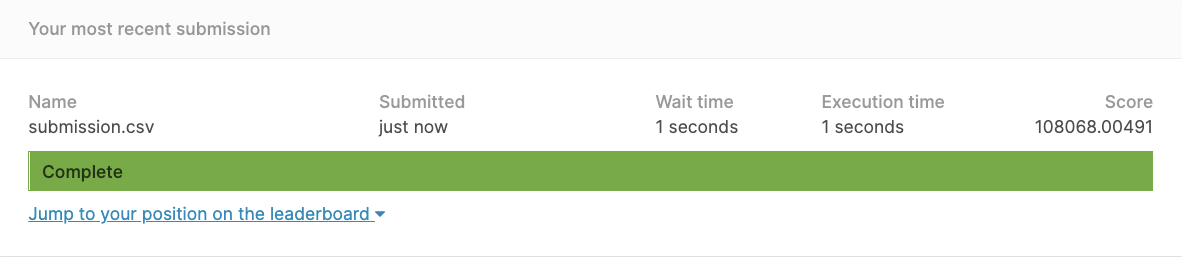

**목표 스코어 달성!**

# References
- https://dining-developer.tistory.com/4
- https://www.kaggle.com/lifesailor/xgboost
- https://injo.tistory.com/48
- https://smecsm.tistory.com/133
- https://dailyheumsi.tistory.com/136